In [1]:
import torch
from tqdm import tqdm

from matplotlib import pyplot as plt

from dataset import MedMNISTv2, positional_embedding
from models import UNet

In [2]:
device = torch.device("cpu")

net = UNet(in_channels=2, out_channels=1).to(device)
checkpoint = torch.load("logs/checkpoint_128.pt", map_location="cpu")
net.load_state_dict(checkpoint["net_state_dict"])
print(checkpoint['epoch'])

timesteps = 1000
dataset = MedMNISTv2("val_images")
beta = dataset.get_beta()

127
Using downloaded and verified file: ./data/chestmnist.npz


Text(0.5, 0, 'epoch')

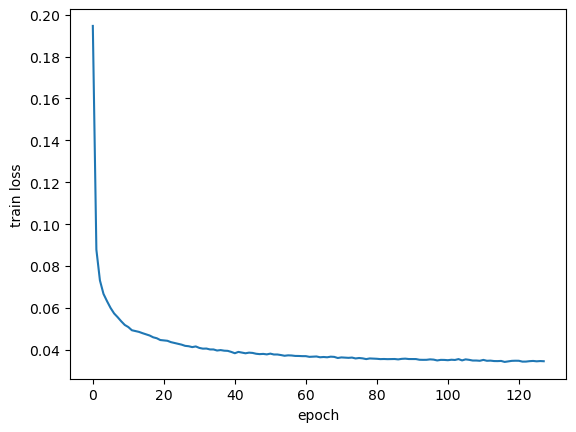

In [3]:
fig, ax = plt.subplots()

ax.plot(checkpoint["losses"])
ax.set_ylabel("train loss")
ax.set_xlabel("epoch")

001, 0.0064: 100%|████████████████████████████| 998/998 [00:12<00:00, 78.16it/s]


tensor(459.2044)


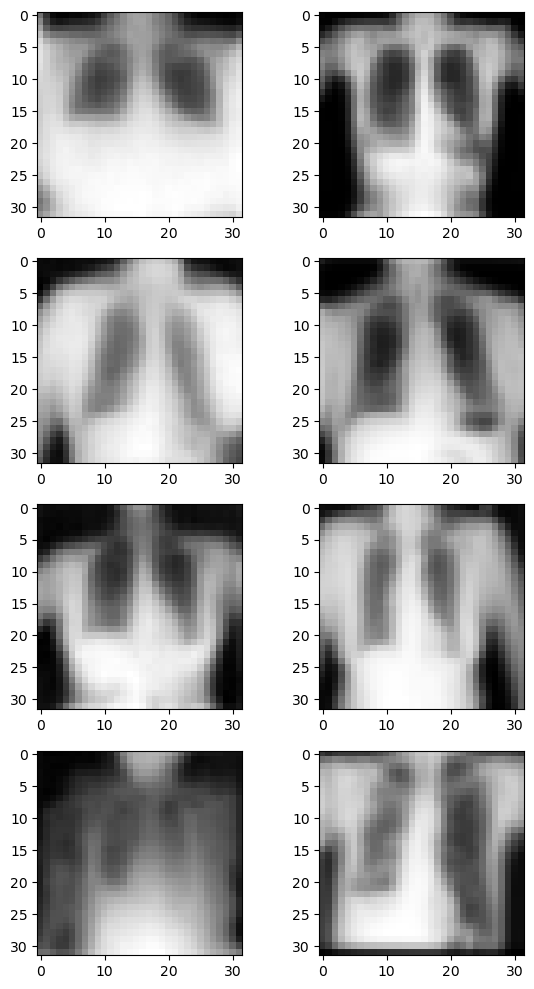

In [6]:
batch_size = 4
timesteps = 999
x_0 = torch.concat(
    (
        dataset._get(0, timesteps)[0].unsqueeze(0).to(device),
        dataset._get(1, timesteps)[0].unsqueeze(0).to(device),
        dataset._get(2, timesteps)[0].unsqueeze(0).to(device),
        dataset._get(3, timesteps)[0].unsqueeze(0).to(device)
    ),
    dim=0
)
x_t = torch.concat(
    (
        dataset._get(0, timesteps)[1].unsqueeze(0).to(device),
        dataset._get(1, timesteps)[1].unsqueeze(0).to(device),
        dataset._get(2, timesteps)[1].unsqueeze(0).to(device),
        dataset._get(3, timesteps)[1].unsqueeze(0).to(device)
    ),
    dim=0
)
x_t = torch.randn(batch_size, 1, 32, 32).to(device)

with torch.inference_mode():
    steps = tqdm(range(1, timesteps)[::-1])
    for t in steps:
        # embed_timestep along channel dim
        t_embedding = positional_embedding(t, d=32).repeat((batch_size, 1, 32, 1)).to(device)
        x_t_embed = torch.concat((x_t, t_embedding), dim=1)

        eps_pred = net(x_t_embed)
        
        alpha_t = 1-beta[t]
        alpha_bar_t = torch.prod(1-beta[:t+1])
        z = torch.randn(batch_size, 1, 32, 32)
        sigma_t = torch.sqrt(beta[t]) if t > 0 else 0
        x_t = 1/torch.sqrt(alpha_t)*(x_t-(1-alpha_t)/torch.sqrt(1-alpha_bar_t)*eps_pred) + sigma_t*z
        steps.set_description(f"{t:03d}, {sigma_t:.4f}")

    print(torch.nn.functional.mse_loss(x_t, x_0))

fig, ax = plt.subplots(4, 2, figsize=(6, 10))
ax[0,0].imshow(x_t[0,0].detach().cpu().numpy(), cmap='gray')
ax[0,1].imshow(dataset._get(0, 999)[0][0].cpu().numpy(), cmap='gray')
ax[1,0].imshow(x_t[1,0].detach().cpu().numpy(), cmap='gray')
ax[1,1].imshow(dataset._get(1, 999)[0][0].cpu().numpy(), cmap='gray')
ax[2,0].imshow(x_t[2,0].detach().cpu().numpy(), cmap='gray')
ax[2,1].imshow(dataset._get(2, 999)[0][0].cpu().numpy(), cmap='gray')
ax[3,0].imshow(x_t[3,0].detach().cpu().numpy(), cmap='gray')
ax[3,1].imshow(dataset._get(3, 999)[0][0].cpu().numpy(), cmap='gray')
fig.tight_layout()
plt.show()